## Tugas Besar II IF3270 Pembelajaran Mesin - RNN

### Anggota Kelompok:
1. Suthasoma Mahardhika Munthe (13522098)
2. Marvin Scifo Y. Hutahaean (13522110)
3. Berto Richardo Togatorop (13522118)

In [1]:
import numpy as np
import pandas as pd
from customnn import RNN, Embedded, FullyConnected, Dropout
from keras import layers
from keras import models
from sklearn.metrics import classification_report, accuracy_score

url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/train.csv"
url_valid = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/valid.csv"
url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/main/datasets/sentiment/indonesian/test.csv"

df_train = pd.read_csv(url_train)
df_valid = pd.read_csv(url_valid)
df_test = pd.read_csv(url_test)

In [2]:
max_tokens = 10000
output_sequence_length = 100

vectorizer = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_sequence_length
)
vectorizer.adapt(df_train['text'])
vectorizer_data = vectorizer(df_train['text'])
vectorizer_test = vectorizer(df_test['text'])
vectorizer_val = vectorizer(df_valid['text'])
vocabs = len(vectorizer.get_vocabulary())

y_train = df_train['label'].to_numpy()
y_test = df_test['label'].to_numpy()
y_val = df_valid['label'].to_numpy()

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_int = le.fit_transform(df_train['label'])
y_test_int = le.transform(df_test['label'])
y_valid_int = le.transform(df_valid['label'])

In [4]:
rnn_model = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.SimpleRNN(units=64),
    layers.Dropout(0.5),
    layers.Dense(units=3, activation='softmax')
])

rnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
rnn_model.fit(
    vectorizer_data, y_train_int,
    epochs=8,
    batch_size=64
)
test_loss, test_acc = rnn_model.evaluate(vectorizer_val, y_valid_int)
print(test_loss, test_acc)

Epoch 1/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3380 - loss: 1.1270
Epoch 2/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4986 - loss: 1.0293
Epoch 3/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6235 - loss: 0.8412
Epoch 4/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8076 - loss: 0.6094
Epoch 5/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9416 - loss: 0.4037
Epoch 6/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9732 - loss: 0.2708
Epoch 7/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9919 - loss: 0.1604
Epoch 8/8
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9968 - loss: 0.1115
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5670 - loss: 1.2267 
1.3063658475875854 0.5400000214576721


In [5]:
embedding_weights = rnn_model.layers[0].get_weights()[0]
rnn_weights = rnn_model.layers[1].get_weights()
kernel, recurrent_kernel, bias_rnn = rnn_weights
dense_weights = rnn_model.layers[3].get_weights()
kernel_dense, bias_dense = dense_weights

In [6]:
from sklearn.metrics import f1_score

class RNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=False)
        self.drop = Dropout(dropout_rate=0.5)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=64, output_size=3, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.rnn1.forward(self.embedding.forward(x))))
    
rnn_from_scratch = RNNFromScratch(vocabs=vocabs)

rnn_from_scratch.embedding.weight = embedding_weights.copy()
rnn_from_scratch.rnn1.input_weights = kernel.copy()
rnn_from_scratch.rnn1.hidden_weights = recurrent_kernel.copy()
rnn_from_scratch.rnn1.bias = bias_rnn.copy()
rnn_from_scratch.fc1.weights = kernel_dense.copy()
rnn_from_scratch.fc1.biases = bias_dense.copy()

sample_input = vectorizer_test.numpy()

keras_output = rnn_model(sample_input, training=False).numpy()

outputs = []
for i in range(sample_input.shape[0]):
    x = sample_input[i]
    output = rnn_from_scratch.forward(x)
    outputs.append(output)

outputs = np.stack(outputs)

keras_labels = np.argmax(keras_output, axis=1)
scratch_labels = np.argmax(outputs, axis=1)
keras_accuracy = accuracy_score(np.argmax(keras_output, axis=1), keras_labels)
scratch_accuracy = accuracy_score(keras_labels, scratch_labels)

print("Keras Model Accuracy:", keras_accuracy)
print("From-Scratch Model Accuracy:", scratch_accuracy)

f1 = f1_score(keras_labels, scratch_labels, average='macro')

print("Difference:", np.abs(keras_output - outputs).mean())
print("F1:", f1)


Keras Model Accuracy: 1.0
From-Scratch Model Accuracy: 1.0
Difference: 1.4155702962736557e-07
F1: 1.0


In [8]:
bi_models = models.Sequential([
    layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
    layers.Bidirectional(layers.SimpleRNN(units=64)),
    layers.Dropout(0.5),
    layers.Dense(units=3, activation='softmax')
])
bi_models.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
bi_models.fit(
    vectorizer_data, y_train_int,
    epochs=10,
    batch_size=64
)
test_loss, test_acc = bi_models.evaluate(vectorizer_val, y_valid_int)
print(test_loss, test_acc)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4123 - loss: 1.0758
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5843 - loss: 0.9421
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7576 - loss: 0.7482
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8807 - loss: 0.5302
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9617 - loss: 0.3369
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9838 - loss: 0.2110
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9996 - loss: 0.1314
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 0.0717
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 0.0373
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9968 - loss: 0.0310
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5098 - loss: 0.8777 
0.8582795858383179 0.5400000214576721


In [9]:
bi_embedding_weights = bi_models.layers[0].get_weights()[0]
bi_rnn_weights = bi_models.layers[1].get_weights()
bi_kernel, bi_recurrent_kernel, bi_bias_rnn, bi_kernel_reverse, bi_recurrent_kernel_reverse, bi_bias_rnn_reverse = bi_rnn_weights
bi_dense_weights = bi_models.layers[3].get_weights()
bi_kernel_dense, bi_bias_dense = bi_dense_weights

In [ ]:
class BiRNNFromScratch:
    def __init__(self, vocabs: int):
        self.embedding = Embedded(vocabs, 100, embeddings_initializer='uniform')
        self.rnn1 = RNN(unit=64, input_size=100, timestep=100, return_sequence=False, bidirectional=True)
        self.drop = Dropout(dropout_rate=0.5)
        self.drop.training_status = False
        self.fc1 = FullyConnected(input_size=128, output_size=3, activation='softmax', weight_init='xavier',
                                  lower=-0.05, upper=0.05, mean=0, variance=1, seed=None, use_rmsnorm=False)

    def forward(self, x):
        return self.fc1.forward(self.drop.forward(self.rnn1.forward(self.embedding.forward(x))))
    
bi_rnn_from_scratch = BiRNNFromScratch(vocabs=vocabs)

bi_rnn_from_scratch.embedding.weight = bi_embedding_weights.copy()
bi_rnn_from_scratch.rnn1.input_weights = bi_kernel.copy()
bi_rnn_from_scratch.rnn1.hidden_weights = bi_recurrent_kernel.copy()
bi_rnn_from_scratch.rnn1.bias = bi_bias_rnn.copy()
bi_rnn_from_scratch.rnn1.input_weights_reverse = bi_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.hidden_weights_reverse = bi_recurrent_kernel_reverse.copy()
bi_rnn_from_scratch.rnn1.bias_reverse = bi_bias_rnn_reverse.copy()
bi_rnn_from_scratch.fc1.weights = bi_kernel_dense.copy()
bi_rnn_from_scratch.fc1.biases = bi_bias_dense.copy()

bi_sample_input = vectorizer_test.numpy()

bi_keras_output = bi_models(bi_sample_input, training=False).numpy()

bi_outputs = []
for i in range(bi_sample_input.shape[0]):
    x = bi_sample_input[i]
    bi_output = bi_rnn_from_scratch.forward(x)
    bi_outputs.append(bi_output)

bi_outputs = np.stack(bi_outputs)

bi_keras_labels = np.argmax(bi_keras_output, axis=1)
bi_scratch_labels = np.argmax(bi_outputs, axis=1)

bi_f1 = f1_score(bi_keras_labels, bi_scratch_labels, average='macro')
keras_accuracy = accuracy_score(np.argmax(bi_keras_output, axis=1), bi_keras_labels)
scratch_accuracy = accuracy_score(bi_keras_labels, bi_scratch_labels)

print("Keras Model Accuracy:", keras_accuracy)
print("From-Scratch Model Accuracy:", scratch_accuracy)

# I'm adding something

print("Difference:", np.abs(bi_keras_output - bi_outputs).mean())
print("F1:",bi_f1)


Keras Model Accuracy: 1.0
From-Scratch Model Accuracy: 1.0
Difference: 2.4797589996265234e-07
F1: 1.0


In [11]:
# RNN Models Hyperparameter Analysis
rnn_models = [
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64, return_sequences=True),
        layers.SimpleRNN(units=128, return_sequences=True),
        layers.SimpleRNN(units=256),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=32),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=128),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.SimpleRNN(units=64),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
    models.Sequential([
        layers.Embedding(vocabs, 100, embeddings_initializer='uniform'),
        layers.Bidirectional(layers.SimpleRNN(units=64, return_sequences=True)),
        layers.Bidirectional(layers.SimpleRNN(units=64)),
        layers.Dropout(0.2),
        layers.Dense(units=vocabs, activation='softmax')
    ]),
]

In [12]:
name_layers = [
    "1 Layer",
    "2 Layers",
    "3 Layers",
    "32 Cells",
    "64 Cells",
    "128 Cells",
    "Unidirectional",
    "Bidirectional",
    "Bidirectional 2 Layers"
]

1 Layer
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.4083 - loss: 1.4939 - val_accuracy: 0.3600 - val_loss: 1.2912
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3812 - loss: 1.3052 - val_accuracy: 0.4400 - val_loss: 1.1808
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3654 - loss: 1.2190 - val_accuracy: 0.3600 - val_loss: 1.1301
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3478 - loss: 1.1555 - val_accuracy: 0.4400 - val_loss: 1.1003
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3519 - loss: 1.1456 - val_accuracy: 0.3600 - val_loss: 1.0925
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3931 - loss: 1.1194 - val_accuracy: 0.3600 - val_loss: 1.0862
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4106 - loss: 1.1132 - val_accuracy: 0.3600 - val_loss: 1.0791
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4054 - loss: 1.0973 - val_accuracy: 0.3600 - val_loss: 1.0753


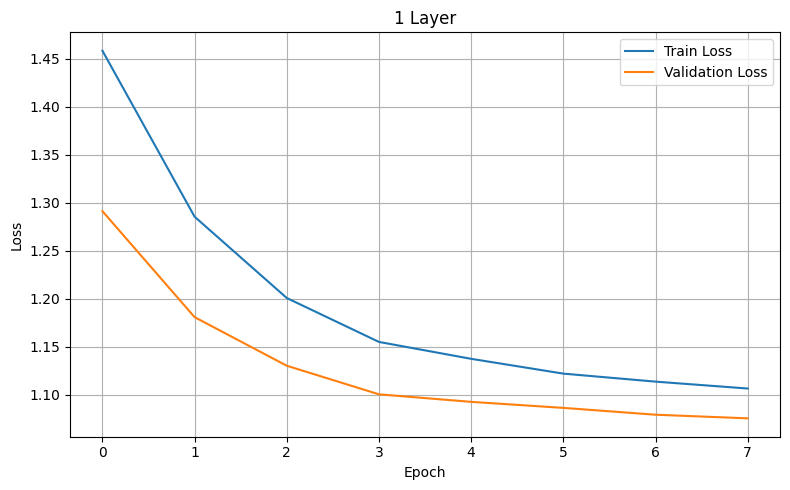


2 Layers
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.3966 - loss: 1.0989 - val_accuracy: 0.4400 - val_loss: 1.0680
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3416 - loss: 1.1188 - val_accuracy: 0.4400 - val_loss: 1.0663
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3850 - loss: 1.0903 - val_accuracy: 0.3600 - val_loss: 1.0625
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3753 - loss: 1.0991 - val_accuracy: 0.3600 - val_loss: 1.0695
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3687 - loss: 1.0939 - val_accuracy: 0.4400 - val_loss: 1.0574
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3714 - loss: 1.0954 - val_accuracy: 0.3600 - val_loss: 1.0681
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3622 - loss: 1.0906 - val_accuracy: 0.3600 - val_loss: 1.0684
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3546 - loss: 1.0842 - val_accuracy: 0.4400 - val_loss: 1.065

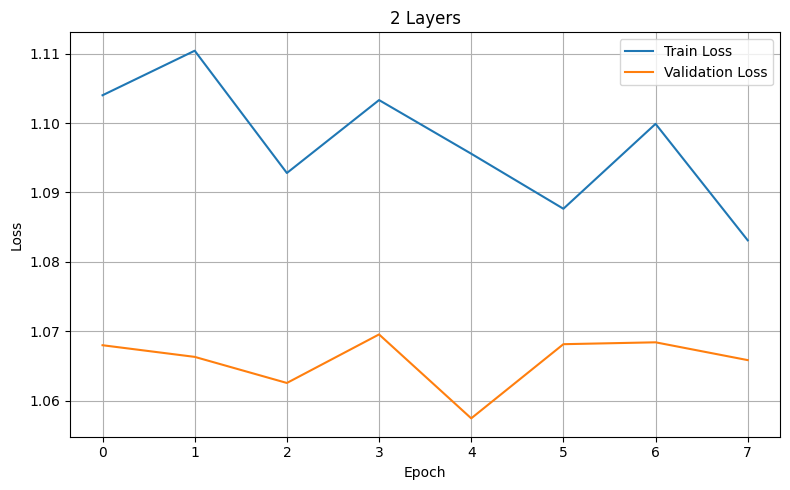


3 Layers
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.3774 - loss: 1.1001 - val_accuracy: 0.4400 - val_loss: 1.0720
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.3718 - loss: 1.1003 - val_accuracy: 0.3600 - val_loss: 1.0815
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3652 - loss: 1.1347 - val_accuracy: 0.3600 - val_loss: 1.0611
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3358 - loss: 1.1138 - val_accuracy: 0.4400 - val_loss: 1.0562
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3674 - loss: 1.0904 - val_accuracy: 0.3600 - val_loss: 1.0972
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3426 - loss: 1.1096 - val_accuracy: 0.4400 - val_loss: 1.0546
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3984 - loss: 1.1036 - val_accuracy: 0.3600 - val_loss: 1.0562
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.3909 - loss: 1.1007 - val_accuracy: 0.4400 - val_loss: 1.06

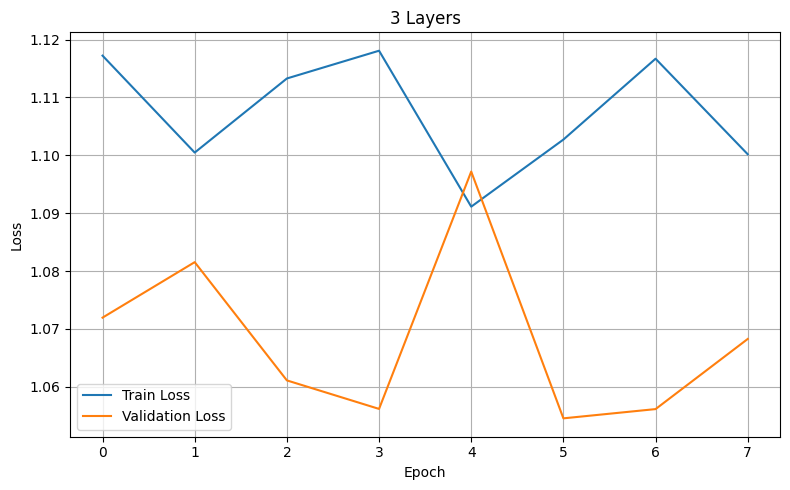


32 Cells
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3651 - loss: 3.8899 - val_accuracy: 0.4400 - val_loss: 3.5044
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3998 - loss: 3.4568 - val_accuracy: 0.4400 - val_loss: 3.1028
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3553 - loss: 3.0498 - val_accuracy: 0.4400 - val_loss: 2.7304
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3921 - loss: 2.6975 - val_accuracy: 0.4400 - val_loss: 2.3961
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3503 - loss: 2.3486 - val_accuracy: 0.4400 - val_loss: 2.1105
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3783 - loss: 2.0935 - val_accuracy: 0.4400 - val_loss: 1.8774
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4099 - loss: 1.8780 - val_accuracy: 0.4400 - val_loss: 1.6949
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3772 - loss: 1.7363 - val_accuracy: 0.4400 - val_loss: 1.556

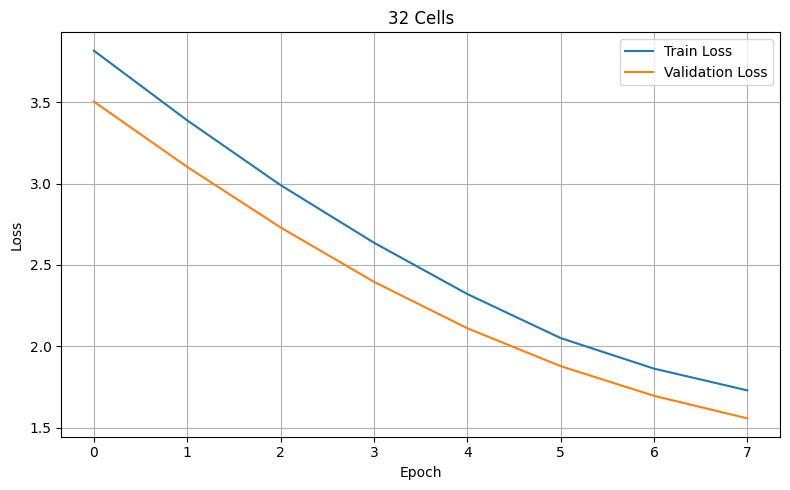


64 Cells
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3388 - loss: 1.5411 - val_accuracy: 0.4400 - val_loss: 1.2988
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3485 - loss: 1.3200 - val_accuracy: 0.4400 - val_loss: 1.1818
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3913 - loss: 1.2035 - val_accuracy: 0.4400 - val_loss: 1.1241
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3314 - loss: 1.1704 - val_accuracy: 0.3600 - val_loss: 1.1073
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3700 - loss: 1.1348 - val_accuracy: 0.3600 - val_loss: 1.0949
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3655 - loss: 1.1387 - val_accuracy: 0.3600 - val_loss: 1.0930
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3742 - loss: 1.1264 - val_accuracy: 0.3600 - val_loss: 1.0902
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3906 - loss: 1.1138 - val_accuracy: 0.3600 - val_loss: 1.077

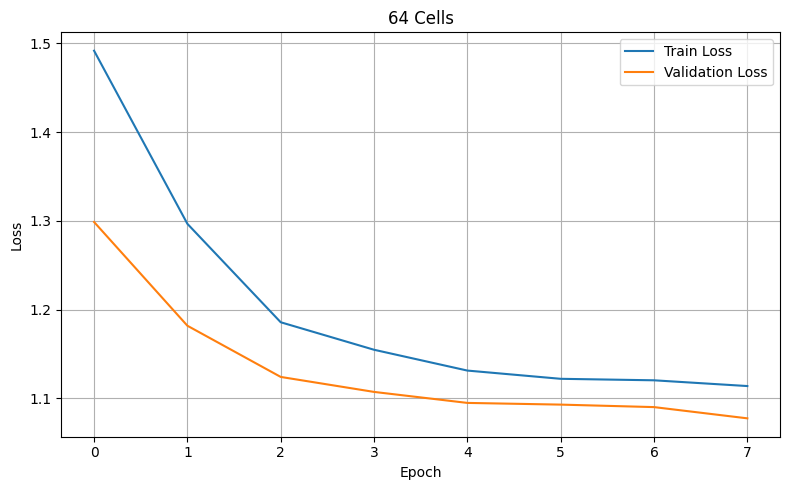


128 Cells
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.3513 - loss: 1.1262 - val_accuracy: 0.3600 - val_loss: 1.0747
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4166 - loss: 1.0861 - val_accuracy: 0.4400 - val_loss: 1.0564
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3667 - loss: 1.1075 - val_accuracy: 0.3600 - val_loss: 1.0663
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4177 - loss: 1.0785 - val_accuracy: 0.3600 - val_loss: 1.0708
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4174 - loss: 1.0990 - val_accuracy: 0.3600 - val_loss: 1.0742
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3901 - loss: 1.0959 - val_accuracy: 0.3600 - val_loss: 1.0600
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3970 - loss: 1.0826 - val_accuracy: 0.3600 - val_loss: 1.0607
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3512 - loss: 1.0960 - val_accuracy: 0.3600 - val_loss: 1.06

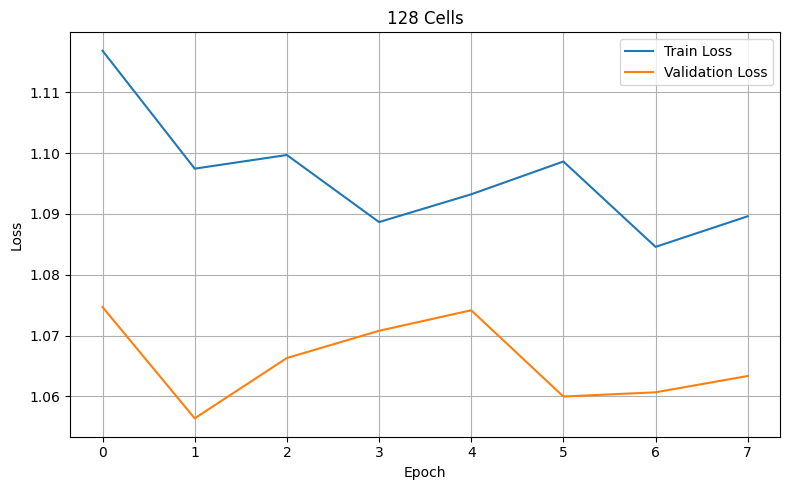


Unidirectional
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.3492 - loss: 1.5500 - val_accuracy: 0.3600 - val_loss: 1.2898
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3577 - loss: 1.2957 - val_accuracy: 0.3600 - val_loss: 1.1928
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4018 - loss: 1.1953 - val_accuracy: 0.3600 - val_loss: 1.1421
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3846 - loss: 1.1496 - val_accuracy: 0.3600 - val_loss: 1.1097
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3898 - loss: 1.1309 - val_accuracy: 0.4400 - val_loss: 1.0908
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4187 - loss: 1.1178 - val_accuracy: 0.3600 - val_loss: 1.0859
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4203 - loss: 1.1121 - val_accuracy: 0.3600 - val_loss: 1.0826
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3741 - loss: 1.1069 - val_accuracy: 0.3600 - val_loss:

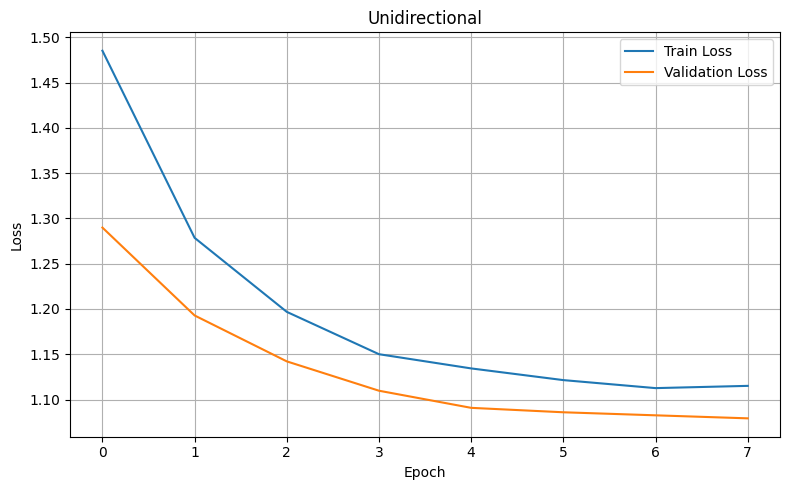


Bidirectional
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.3876 - loss: 1.1145 - val_accuracy: 0.3600 - val_loss: 1.0667
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3804 - loss: 1.1004 - val_accuracy: 0.4400 - val_loss: 1.0593
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4380 - loss: 1.0736 - val_accuracy: 0.4000 - val_loss: 1.0684
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3324 - loss: 1.1200 - val_accuracy: 0.3600 - val_loss: 1.0767
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3548 - loss: 1.0950 - val_accuracy: 0.3600 - val_loss: 1.0631
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3715 - loss: 1.0968 - val_accuracy: 0.4500 - val_loss: 1.0512
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4281 - loss: 1.0710 - val_accuracy: 0.5100 - val_loss: 1.0565
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5362 - loss: 1.0489 - val_accuracy: 0.5200 - val_loss: 

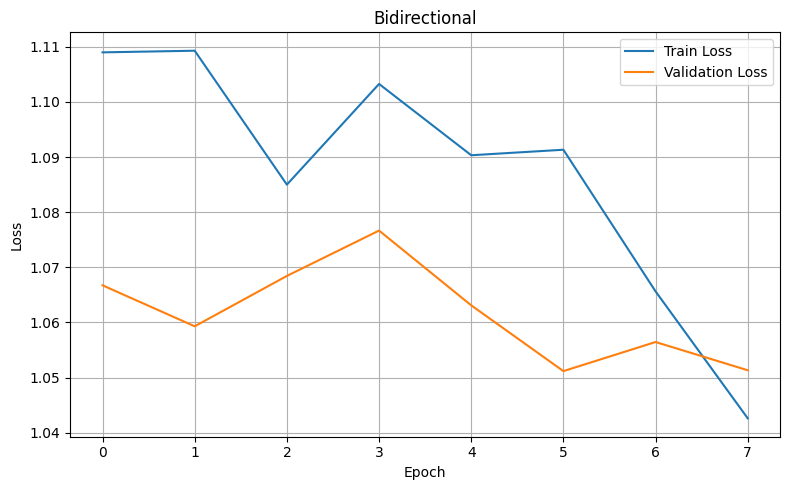


Bidirectional 2 Layers
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.4659 - loss: 1.1508 - val_accuracy: 0.4400 - val_loss: 1.0679
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.3481 - loss: 1.1087 - val_accuracy: 0.4400 - val_loss: 1.0881
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3570 - loss: 1.1052 - val_accuracy: 0.3600 - val_loss: 1.0719
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4214 - loss: 1.0940 - val_accuracy: 0.3600 - val_loss: 1.0640
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3767 - loss: 1.1131 - val_accuracy: 0.4400 - val_loss: 1.0586
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3775 - loss: 1.0998 - val_accuracy: 0.4400 - val_loss: 1.0745
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3726 - loss: 1.0957 - val_accuracy: 0.4400 - val_loss: 1.0632
Epoch 8/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3904 - loss: 1.0870 - val_accuracy: 0.3700 - 

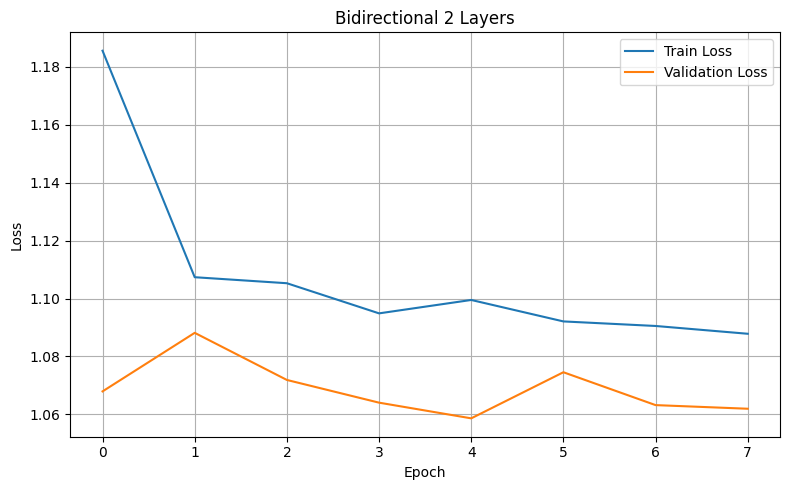

In [14]:
import matplotlib.pyplot as plt

n = 0

for model in rnn_models:
    print(name_layers[n])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=['accuracy']
    )
    history = model.fit(
        vectorizer_data, y_train_int,
        epochs=8,
        batch_size=64,
        validation_split=0.2
    )
    test_loss, test_acc = model.evaluate(vectorizer_val, y_valid_int)

    y_pred_probs = model.predict(vectorizer_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    f1 = f1_score(y_valid_int, y_pred, average='macro')

    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score: {f1:.4f}")

    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name_layers[n])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    n += 1
    print()

